In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Importing Required Libraries

import numpy as np # linear algebra, NumPy lib.
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), Pandas lib.
import seaborn as sns # Seaborn lib.
import matplotlib.pyplot as plt # Matplotlib lib.
import sklearn as sk # Sklearn lib.
import tensorflow as tf # Tensorflow lib.

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from keras.models import Model
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import sys
np.set_printoptions(threshold=sys.maxsize)
# import warnings
import warnings
# filter warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the Dataset
# Reading the data for training the model
labels = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
train = "/kaggle/input/dog-breed-identification/train/"
test ="/kaggle/input/dog-breed-identification/test/"

In [3]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels.shape

(10222, 2)

In [5]:
labels.info()  # labels.csv file has 10222 rows and 2 columns (id and breed)
labels.isnull().values.any()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


False

In [6]:
labels_type=type(labels["breed"].head())

print(labels_type)

breed_names = labels["breed"].unique()

print("The number of dog breed =",len(breed_names))

breed_counts=labels["breed"].value_counts()

print(breed_counts)

breed_index=labels["breed"].index

print(breed_index)


<class 'pandas.core.series.Series'>
The number of dog breed = 120
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64
RangeIndex(start=0, stop=10222, step=1)


In [7]:
# Data splitting
# Selecting first 35 breed classes which has highest value counts
new_breed_indexes=breed_counts[breed_counts > 89].index
print(new_breed_indexes)

new_labels = labels[labels["breed"].isin(new_breed_indexes)].reset_index(drop=True)

new_breed_counts=new_labels["breed"].value_counts()

print(new_breed_counts)

new_breed_names = new_labels["breed"].unique()

print("Selected number of dog breed from breed list=",len(new_breed_names))

print(new_labels)  # now labels file reduced to 3587 rows and 2 columns (id and breed) and saved as new_labels

Index(['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher',
       'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian',
       'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg',
       'cairn', 'beagle', 'japanese_spaniel', 'australian_terrier',
       'blenheim_spaniel', 'miniature_pinscher', 'irish_wolfhound',
       'lakeland_terrier', 'saluki', 'papillon', 'norwegian_elkhound',
       'whippet', 'siberian_husky', 'pug', 'chow', 'italian_greyhound',
       'pembroke', 'ibizan_hound', 'border_terrier', 'newfoundland', 'lhasa',
       'silky_terrier'],
      dtype='object', name='breed')
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
tibetan_terrier         107
airedale                107
leonberg          

In [8]:
new_labels.head()

,id,breed
0,003df8b8a8b05244b1d920bb6cf451f9,basenji
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,00693b8bc2470375cc744a6391d397ec,maltese_dog
3,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier
4,00bee065dcec471f26394855c5c2f3de,cairn


In [9]:

new_labels["filepath"] = "/kaggle/input/dog-breed-identification/train/" + new_labels["id"] + ".jpg"
new_labels.head()

,id,breed,filepath
0,003df8b8a8b05244b1d920bb6cf451f9,basenji,/kaggle/input/dog-breed-identification/train/0...
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,/kaggle/input/dog-breed-identification/train/0...
2,00693b8bc2470375cc744a6391d397ec,maltese_dog,/kaggle/input/dog-breed-identification/train/0...
3,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier,/kaggle/input/dog-breed-identification/train/0...
4,00bee065dcec471f26394855c5c2f3de,cairn,/kaggle/input/dog-breed-identification/train/0...


In [10]:
# Reading and resizing images

resized_images = []

for x in range(len(new_labels)):
    img = cv2.imread(new_labels.loc[x, "filepath"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (128, 128))
    resized_images.append(img_rgb_resized)
    
resized_images_array = np.array(resized_images)

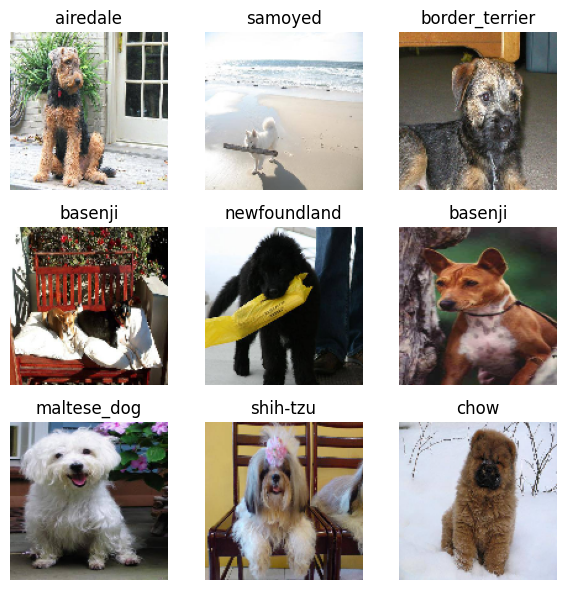

In [11]:

# Selecting 9 images from the array of resized images randomly
# Displaying them with their labels

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    k = np.random.randint(0, len(new_labels))
    plt.imshow(resized_images_array[k])
    plt.title(new_labels.loc[k, "breed"])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
# Label Encoding or One-Hot Encoding techniques to deal with categorical targets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
lencoder = LabelEncoder()
new_labels["breed"]= lencoder.fit_transform(new_labels["breed"])
new_labels.head(15)


,id,breed,filepath
0,003df8b8a8b05244b1d920bb6cf451f9,3,/kaggle/input/dog-breed-identification/train/0...
1,0042188c895a2f14ef64a918ed9c7b64,29,/kaggle/input/dog-breed-identification/train/0...
2,00693b8bc2470375cc744a6391d397ec,19,/kaggle/input/dog-breed-identification/train/0...
3,007ff9a78eba2aebb558afea3a51c469,16,/kaggle/input/dog-breed-identification/train/0...
4,00bee065dcec471f26394855c5c2f3de,8,/kaggle/input/dog-breed-identification/train/0...
5,00ddcec076073cc96f82c27bf4548fbc,12,/kaggle/input/dog-breed-identification/train/0...
6,011761e3ae8ec5e188e8f0bcb59bb8b6,16,/kaggle/input/dog-breed-identification/train/0...
7,013aed490e0e15a8989e12ae0d0ccfaa,7,/kaggle/input/dog-breed-identification/train/0...
8,013c43f40f0fb13fa25ac0c2a70fd48f,16,/kaggle/input/dog-breed-identification/train/0...
9,013f8fdf6d638c7bb042f5f17e8a9fdc,33,/kaggle/input/dog-breed-identification/train/0...


In [13]:
new_labels["breed"]


0        3
1       29
2       19
3       16
4        8
        ..
3582    33
3583     1
3584    28
3585     1
3586    20
Name: breed, Length: 3587, dtype: int64

In [14]:
cat_labels=to_categorical(new_labels["breed"]-1, num_classes=35)
print(cat_labels[0:5])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
# Splitting dataset into X_train,X_test, X_val, y_train, y_test and y_val
from sklearn.model_selection import train_test_split
x_data = resized_images_array
y_label = cat_labels
X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size=0.15, random_state=30)

In [16]:
print("************************************************************")
print("Train Data Size :",X_train.shape)
print("Test Data Size :",X_test.shape)
print("Train Label Data Size :",y_train.shape)
print("Test Label Data Size :",y_test.shape)
print("************************************************************")

************************************************************
Train Data Size : (3048, 128, 128, 3)
Test Data Size : (539, 128, 128, 3)
Train Label Data Size : (3048, 35)
Test Label Data Size : (539, 35)
************************************************************


In [17]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   rescale=1./255,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

train_all_data = train_datagen.flow(X_train, y_train, batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)
 
# test_all_data = test_datagen.flow(X_test, y_test, batch_size=32)


In [18]:
# Building Convolutional Neural Network (CNN) model
model= tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu",
                                 input_shape=(128,128,3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

In [19]:
# Adding more convolution and max pooling layers
model.add(tf.keras.layers.Conv2D(128, 
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(128, 
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))

In [20]:
# Flattening the convolution layer
model.add(tf.keras.layers.Flatten())

In [21]:
# Adding the dense layer and drpout layer
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

# Adding the dense layer and drpout layer
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

In [22]:
# Adding the output layer which has 35 breed classes 
model.add(tf.keras.layers.Dense(35, activation="softmax"))

In [23]:
# Compiling proposed CNN model 
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 131072)            0

In [24]:
# Training proposed CNN model for 50 epochs
batch_size=32
epochs=50

# model.fit(train_all_data, steps_per_epoch=500, epochs=50, verbose=2, validation_data=(X_test, y_test))
# model.save_weights("first_try.h5")                                           